In [ ]:
# in this version, i will be moving beyond the final project.
# REGRESSION

# Xception with 128 batch size, 10 epochs,                                            MSE = 0.144, R = 0.38, R^2 = 0.145
# Xception with 128 batch size, 25 epochs, 4 hidden tanh units                        MSE = 0.139, R = 0.42, R^2 = 0.176

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from keras.models import Sequential, load_model
import keras_tuner
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fitter import Fitter, get_common_distributions, get_distributions
import random

In [2]:
# load csv
Data = pd.read_csv("C:\\Users\\Joe\\Box\\Wesley\\Learning Analytics\\HUDK 4050\\Final\\Data\\Data_Table_11_elementary.csv")
N = np.shape(Data)[0]

In [3]:
folderpath = "C:\\Users\\Joe\\Box\\Wesley\\Learning Analytics\\HUDK 4050\\Final\\Data\\google_maps_satellite_227_227_16_elementary\\"
img_height = 227
img_width = 227
Images = np.zeros(shape = (N, img_height, img_width, 3))
TestScores = Data.cs_mn_avg_ol

for i in range(N):
    id = Data.school_code[i]
    im = tf.keras.utils.load_img(folderpath + "school_" + str(id) + ".jpg",
                                 grayscale=False, color_mode="rgb")
    Images[i,:,:,:] = im
    
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     id = Data.school_code[i]
#     im = tf.keras.utils.load_img(folderpath + "school_" + str(id) + ".jpg",
#                                  grayscale=False, color_mode="rgb")
#     Images[i,:,:,:] = im
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(Images[i,:,:,:].astype(int))
#     plt.axis("off")

,sumsquare_error,aic,bic,kl_div
beta,0.115887,477.750410,-227306.591129,inf
norm,0.138050,469.652347,-224011.908354,inf


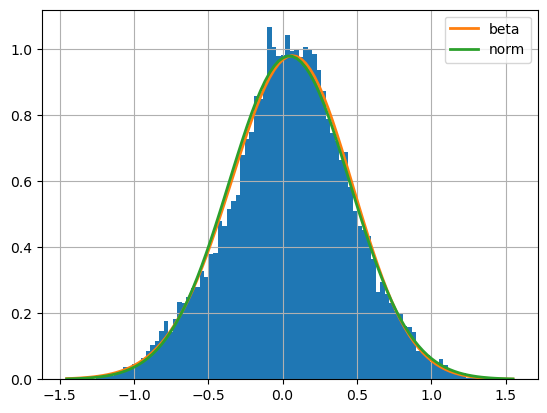

In [4]:
# Data Exploration
f = Fitter(TestScores,
           distributions=['beta',
                          "norm"])
f.fit()
f.summary()

In [5]:
# split into training and testing
frac_train = 0.75
frac_val = 0.15
frac_test = 0.1
num_train = np.round(frac_train*N).astype(int)
num_val = np.round(frac_val*N).astype(int)
num_test = N - num_train - num_val
ind = np.random.RandomState(seed=42).permutation(N)
ind_train = ind[range(num_train)]
ind_val = ind[range(num_train,num_train+num_val)]
ind_test = ind[range(num_train+num_val,num_train+num_val+num_test)]

x_train = Images[ind_train,:,:,:]
y_train = TestScores[ind_train]
x_val = Images[ind_val,:,:,:]
y_val = TestScores[ind_val]
x_test = Images[ind_test,:,:,:]
y_test = TestScores[ind_test]

print(N)
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_val))
print(np.shape(y_val))
print(np.shape(x_test))
print(np.shape(y_test))
print(ind[0:5]) # should be [14690  1444   351 18769  5916]

18939
(14204, 227, 227, 3)
(14204,)
(2841, 227, 227, 3)
(2841,)
(1894, 227, 227, 3)
(1894,)
[14690  1444   351 18769  5916]


In [6]:
#Load the Xception pre-trained model
#include_top=False means that you’re not interested in the last layer of the model. You will be creating and training this layer yourself.
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)
#To prevent the base model being retrained
base_model.trainable = False
inputs = keras.Input(shape=(img_height, img_width, 3))
# data augmentation
x = keras.Sequential([layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                      layers.RandomBrightness(factor=0.2),
                      layers.RandomRotation(0.1),
                      layers.RandomZoom(0.1)])(inputs)
#Preprocess inputs as expected by Xception
x = tf.keras.applications.xception.preprocess_input(x)
#Build the last layers
#Use the functional API method in Keras to illustrate this approach
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Dense(32, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.05))(x) # extra hidden layer
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation='linear', kernel_initializer=initializers.RandomNormal(stddev=0.5))(x) # number of classes
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=tf.keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None))

# loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
# loss=tf.keras.losses.MeanAbsoluteError(reduction="auto", name="mean_absolute_error")
# loss=tf.keras.losses.MeanAbsolutePercentageError(reduction="auto", name="mean_absolute_percentage_error")
# maybe others: https://keras.io/api/losses/regression_losses/

In [7]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 227, 227, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 227, 227, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 227, 227, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [ ]:
# for layer in model.layers: layer.trainable = True
# print(model.trainable_variables)

In [13]:
# history = model.fit(x_train, y_train,
#                     batch_size=128,
#                     epochs=75,
#                     verbose=2,
#                     validation_data=(x_val, y_val)
# )

history2 = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=25,
                    verbose=2,
                    validation_data=(x_val, y_val)
)

Epoch 1/25
111/111 - 521s - loss: 0.1410 - mean_squared_error: 0.1410 - val_loss: 0.1436 - val_mean_squared_error: 0.1436 - 521s/epoch - 5s/step
Epoch 2/25
111/111 - 497s - loss: 0.1403 - mean_squared_error: 0.1403 - val_loss: 0.1431 - val_mean_squared_error: 0.1431 - 497s/epoch - 4s/step
Epoch 3/25
111/111 - 497s - loss: 0.1415 - mean_squared_error: 0.1415 - val_loss: 0.1429 - val_mean_squared_error: 0.1429 - 497s/epoch - 4s/step
Epoch 4/25
111/111 - 496s - loss: 0.1403 - mean_squared_error: 0.1403 - val_loss: 0.1433 - val_mean_squared_error: 0.1433 - 496s/epoch - 4s/step
Epoch 5/25
111/111 - 496s - loss: 0.1392 - mean_squared_error: 0.1392 - val_loss: 0.1393 - val_mean_squared_error: 0.1393 - 496s/epoch - 4s/step
Epoch 6/25
111/111 - 496s - loss: 0.1412 - mean_squared_error: 0.1412 - val_loss: 0.1394 - val_mean_squared_error: 0.1394 - 496s/epoch - 4s/step
Epoch 7/25
111/111 - 499s - loss: 0.1406 - mean_squared_error: 0.1406 - val_loss: 0.1434 - val_mean_squared_error: 0.1434 - 499s/e

Text(0.5, 1.0, 'Training and Loss')

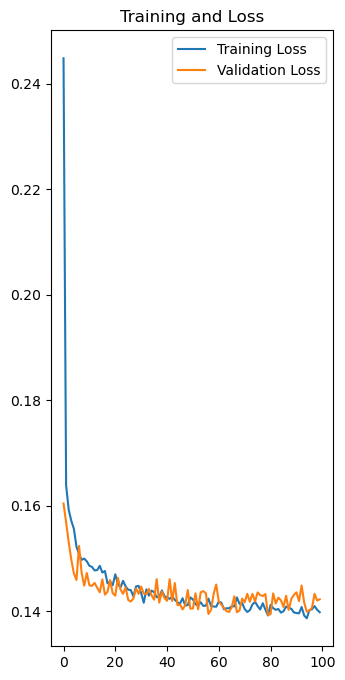

In [27]:
#Plot training and test loss
mse_train = history.history['mean_squared_error']
mse_val = history.history['val_mean_squared_error']

mse_train = np.concatenate((mse_train,history2.history['mean_squared_error']))
mse_val = np.concatenate((mse_val,history2.history['val_mean_squared_error']))

epochs_range = range(np.shape(acc)[0])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mse_train, label='Training Loss')
plt.plot(epochs_range, mse_val, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Loss')


In [23]:
# make predictions
y_pred = np.zeros(shape = (np.shape(x_test)[0]))
for i in range(np.shape(x_test)[0]):
    im = x_test[i,:,:,:]
    im = im[np.newaxis,:,:,:]
    y_pred[i] = model.predict(im)


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 95ms/step


[[1.         0.42572848]
 [0.42572848 1.        ]]
0.18124474207012


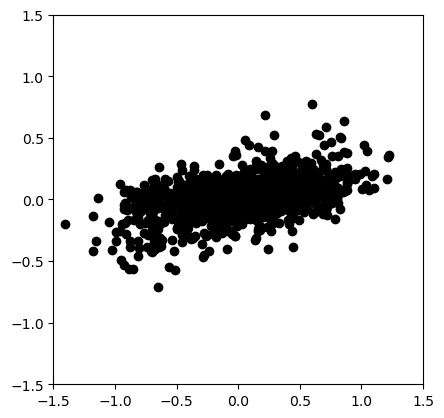

In [24]:
R = np.corrcoef(y_test, y_pred)
print(R)
print(R[0,1]*R[0,1])

plt.plot(y_test, y_pred, 'o', color='black');
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [25]:
# saving the model
modelfilename = "elementary_227_227_zoom_16_regression_2022_12_31_hidden_32_relu.h5"
model.save(modelfilename)
# model = load_model(modelfilename)

In [30]:
# saving other important variables
np.savez('elementary_227_227_zoom_16_regression_2022_12_31_hidden_32_relu_variables.npz',ind=ind,ind_train=ind_train,ind_val=ind_val,ind_test=ind_test,mse_train=mse_train,mse_val=mse_val)

In [ ]:
# plt.hist(y_train, bins=np.arange(-1.5,1.5,0.1))
# plt.show() 


In [ ]:
# last layer weights
# w = np.array(model.layers[9].get_weights())
# plt.hist(w[0], bins=np.arange(-2,0.1,2))
# plt.show() 
# print(np.std(w[0]))

# # second to last layer weights
# w = np.array(model.layers[7].get_weights())
# plt.hist(w[0], bins=np.arange(-0.25,0.25,0.025))
# plt.show() 
# print(np.std(w[0]))
